In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed

# Set default plot font to Times New Roman
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
plt.rcParams["mathtext.fontset"] = "cm"

# Midterm 1 - Niels August Davidsen 
### *(phx)657*

## Two configurations of the 1D ising model

______



In [21]:
def E_neighbor(M, i, neigh_list=None):
    E_i = - M[i] * (
        np.roll(M, 1, axis=0)[i] + 
        np.roll(M, -1, axis=0)[i])
    
    if neigh_list != None:
        E_i -= M[i] * (M[neigh_list[i][0]] + M[neigh_list[i][1]])

    return np.sum(E_i)

def tot_E(M, neigh_list=None):
    E = - 0.5 * M * (np.roll(M, 1, axis=0) + np.roll(M, -1, axis=0))
    E = np.sum(E)

    if neigh_list != None:
        for i, n in enumerate(neigh_list):
            E -= 0.5 * M[i] * (M[n[0]] + M[n[1]])

    return E

def mag(M):
    return np.sum(M) / M.size

def neigh_array(N, extra_edges=2, seed=None, max_tries=1e3):
    if seed is not None:
        np.random.seed(seed)

    adj = np.zeros((N, N), dtype=int)
    
    for i in range(N):
        adj[i, (i-1) % N] = 2
        adj[i, (i+1) % N] = 2

    row_sum = adj.sum(axis=0)
    tries = 0

    adj_clean = adj.copy()

    while np.any(row_sum < 4 + extra_edges):
        i = np.random.randint(N)
        if row_sum[i] >= 4 + extra_edges:
            continue

        possible_js = [j for j in range(N) if j != i and adj[i, j] == 0 and row_sum[j] < 4 + extra_edges]
        if not possible_js:
            tries += 1
            if tries > max_tries:
                adj = adj_clean
                row_sum = adj.sum(axis=0)
                tries = 0
            continue


        j = np.random.choice(possible_js)
        adj[i, j] = 1
        adj[j, i] = 1

        row_sum[i] += 1
        row_sum[j] += 1

    return adj

def adj_mat_to_list(adj):
    neigh_list = []
    for i in range(adj.shape[0]):
        rand_neigh = np.where(adj[i] == 1)[0]
        neigh_list.append([rand_neigh][0])
    return neigh_list

def simp_1d_ising(s_init, T, n0, n_max, J=1, neigh_list=None):
    n = 0
    mag_list = []
    E_list = []
    M = s_init.copy()

    while n < n_max:
        i = np.random.randint(M.size)
        M_flip = M.copy()
        M_flip[i] *= -1

        E_i = E_neighbor(M, i, neigh_list)
        E_i_flip = E_neighbor(M_flip, i, neigh_list)
        dE = E_i_flip - E_i

        if dE < 0 or np.random.uniform() < np.exp(-dE / (T * J)):
            M = M_flip

        n += 1

        if n >= n0:
            mag_list.append(mag(M))
            E_list.append(tot_E(M, neigh_list))

    return mag_list, E_list


def find_tc(mag_list, T_list, threshold=0.05):
    mag_array = np.array(mag_list)
    ind = np.where(mag_array < threshold)[0]
    if len(ind) == 0:
        return None  # No value below the threshold found
    return T_list[ind[0]]

In [3]:
# Example usage of adjacency matrix function

n = 10
adj = neigh_array(n, extra_edges=2)
for line in adj:
    if sum(line) != 6:
        print("error")

adj_list = adj_mat_to_list(adj)

In [ ]:
# Question one: Order parameter (magnetization) as a function of T for both systems

# Parameters
T_list = np.linspace(0.1, 4, 20)
n = 100
s_init = np.random.choice([-1, 1], size=n)
adj_list = adj_mat_to_list(neigh_array(n, extra_edges=2))

run, save = False, False

if run:
    def one_temperature(T):
        """Run simulation for a single temperature T"""
        mag_1d, E_1d = simp_1d_ising(s_init, T, n0=1e4, n_max=1e6, J=1, neigh_list=None)
        mag_1d_neigh, E_1d_neigh = simp_1d_ising(s_init, T, n0=1e4, n_max=1e6, J=1, neigh_list=adj_list)

        return abs(np.mean(mag_1d)), abs(np.mean(mag_1d_neigh))

    # Run in parallel over all T
    results = Parallel(n_jobs=-1)(delayed(one_temperature)(T) for T in T_list)

    # Split into two lists
    mag_1d_list, mag_1d_neigh_list = zip(*results)

    # Save results
    if save:
        df_a = pd.DataFrame({
            "T": T_list,
            "mag_a": mag_1d_list,
            "mag_b": mag_1d_neigh_list})
        df_a.to_csv(
            "/Users/nielsaugustdavidsen/Documents/GitHub/CP_2025/midterm1/question_1_data.csv",
            index=False
        )

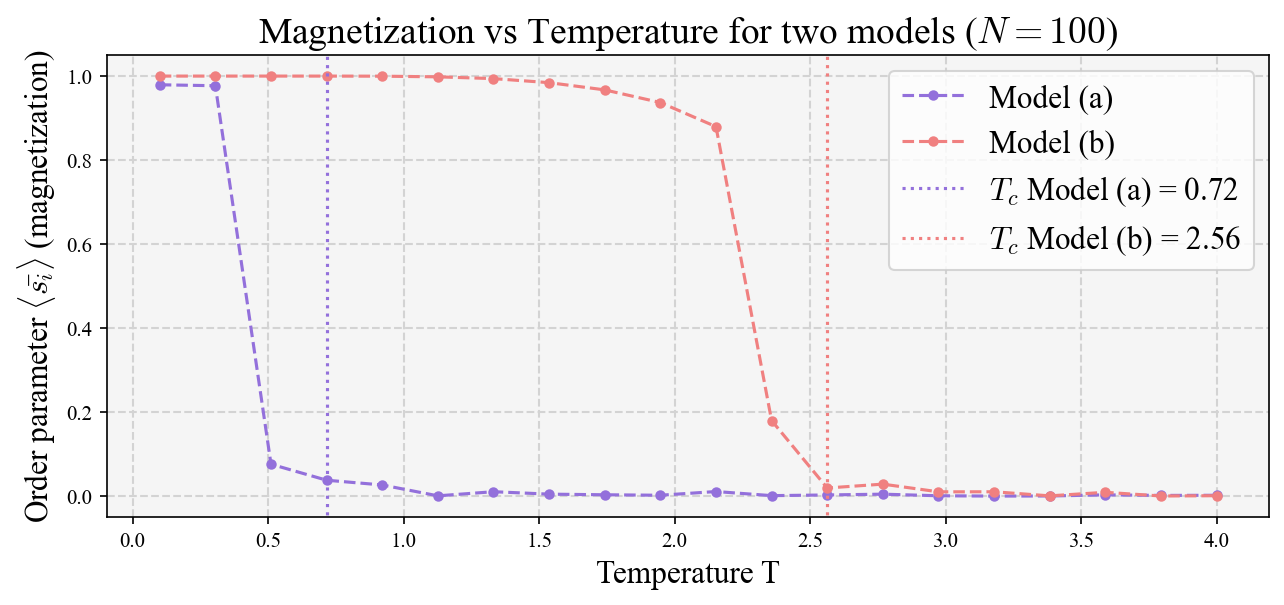

In [43]:
df = pd.read_csv(
    "/Users/nielsaugustdavidsen/Documents/GitHub/CP_2025/midterm1/question_1_data.csv"
)
mag_1d_list = df["mag_a"].values
mag_1d_neigh_list = df["mag_b"].values 

fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
T_list = df["T"].values

ax.plot(T_list, mag_1d_list, label="Model (a)", color='mediumpurple', marker='o', ls='--', markersize=4)
ax.plot(T_list, mag_1d_neigh_list, label="Model (b)", color='lightcoral', marker='o', ls='--', markersize=4)
ax.set_xlabel("Temperature T", fontsize=15)
ax.set_ylabel(r"Order parameter $\langle \bar{s_i} \rangle $ (magnetization)", fontsize=15)
ax.set_facecolor('whitesmoke')
ax.set_title("Magnetization vs Temperature for two models ($N=100$)", fontsize=18)
ax.grid(color='lightgrey', linestyle='--', linewidth=1)


tc_a = find_tc(mag_1d_list, T_list, threshold=0.05)
tc_b = find_tc(mag_1d_neigh_list, T_list, threshold=0.05)

ax.vlines(tc_a, -0.5, 1.2, colors='mediumpurple', linestyles='dotted', label=f'$T_c$ Model (a) = {tc_a:.2f}')
ax.vlines(tc_b, -0.5, 1.2, colors='lightcoral', linestyles='dotted', label=f'$T_c$ Model (b) = {tc_b:.2f}')

ax.legend(fontsize=15);
ax.set_ylim(-0.05, 1.05)

plt.savefig("figurer/midterm1_question1_magnetization.png", bbox_inches='tight')


In [52]:
def T_sim(n, T_list, n_jobs=1):
    s_init = np.random.choice([-1, 1], size=n)
    adj_list = adj_mat_to_list(neigh_array(n, extra_edges=2))

    def one_temp(t):
        mag_a, E_a = simp_1d_ising(s_init, t, n0=1e4, n_max=1e5, J=1, neigh_list=None)
        mag_b, E_b = simp_1d_ising(s_init, t, n0=1e4, n_max=1e5, J=1, neigh_list=adj_list)
        return abs(np.mean(mag_a)), abs(np.mean(mag_b))

    results = Parallel(n_jobs=n_jobs)(delayed(one_temp)(t) for t in T_list)
    mag_a_list, mag_b_list = zip(*results)
    return list(mag_a_list), list(mag_b_list)


In [53]:
# Change "run" and "save" to True to run the simulations and save the data

n_list = [20, 60, 100, 200, 550, 900]
T_list = np.linspace(0.1, 4, 20)


def run_and_save(n_list, T_list, filename="df_lower_n.csv", run=False, save=False, n_jobs=9):
    if run:

        data = {"Temperature": T_list}
        df = pd.DataFrame(data)

        for n in n_list:
            print(f"Running simulations for n={n}")
            mag_a, mag_b = T_sim(n, T_list, n_jobs=n_jobs)
            df[f"Magnetization_a_n{n}"] = mag_a
            df[f"Magnetization_b_n{n}"] = mag_b

            # Save the DF to a csv file and overwrite for each n
            if save:
                df.to_csv(f"/Users/nielsaugustdavidsen/Documents/GitHub/CP_2025/midterm1/{filename}", index=False)

    return None


run_and_save(n_list, T_list, filename="df_final_try.csv", run=True, save=True, n_jobs=9)

Running simulations for n=20
Running simulations for n=60
Running simulations for n=100
Running simulations for n=200
Running simulations for n=550
Running simulations for n=900


[20, 60, 100, 200, 550, 900]


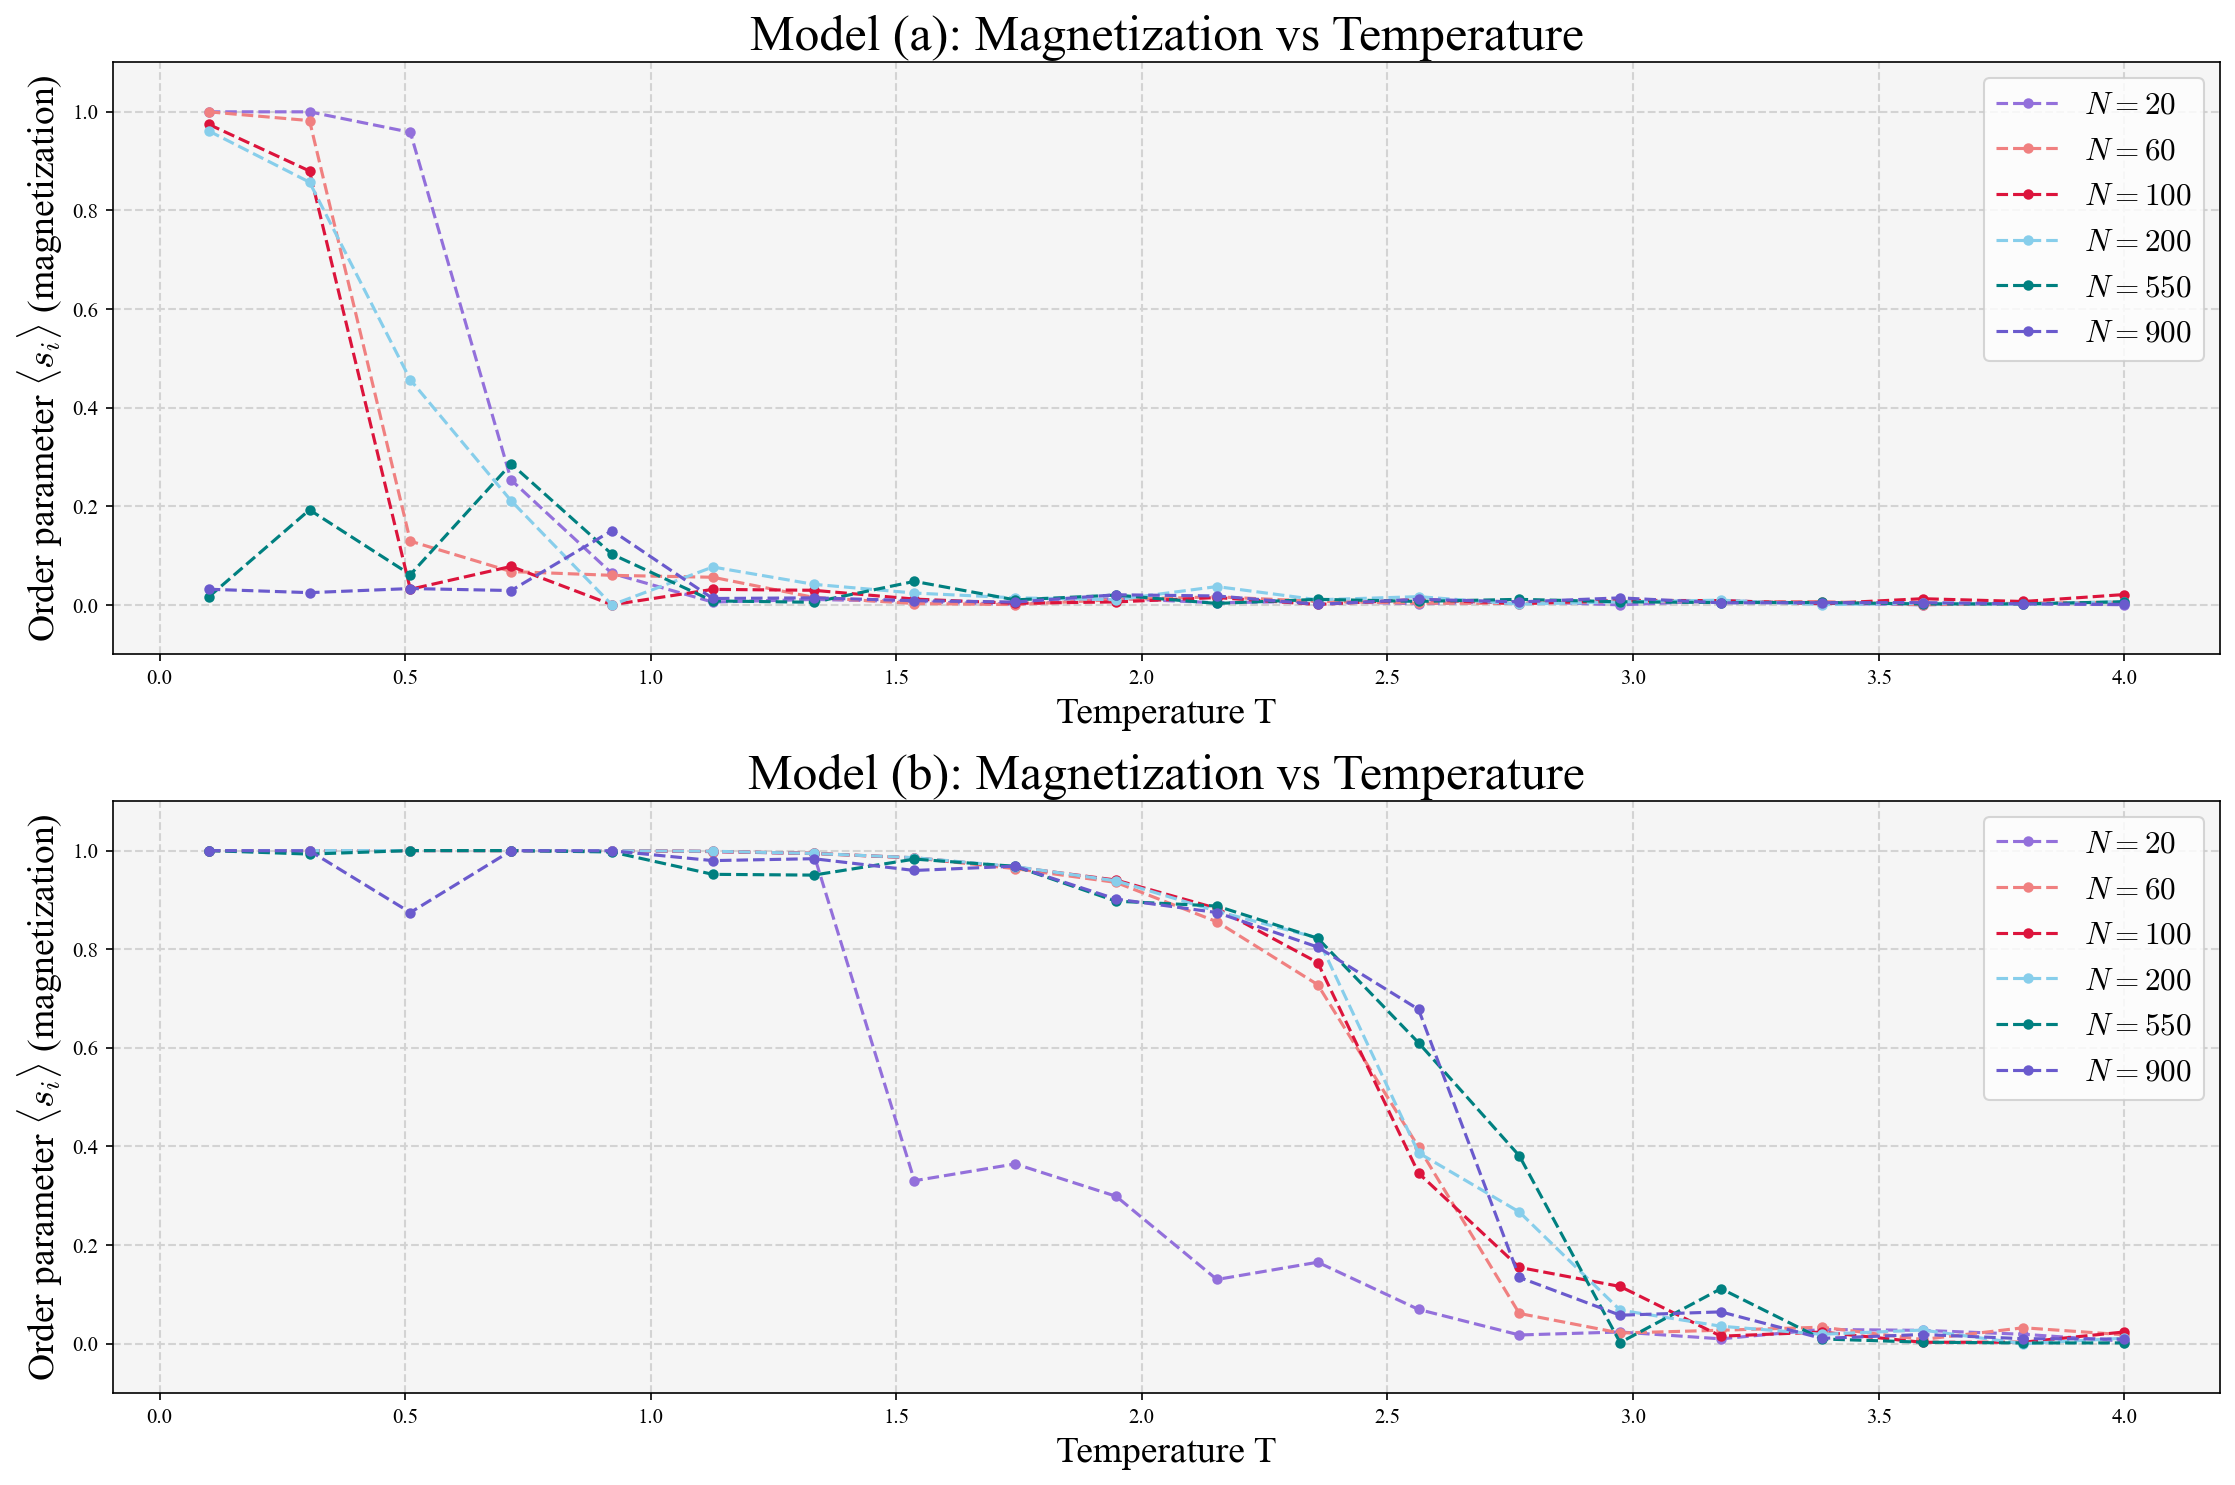

In [60]:
filename = "df_final_try.csv"

df = pd.read_csv(f"/Users/nielsaugustdavidsen/Documents/GitHub/CP_2025/midterm1/{filename}")

# Construct n_list
headers = df.columns
n_list = []
for header in headers:
    if "Magnetization_a_n" in header:
        n = int(header.split("Magnetization_a_n")[1])
        n_list.append(n)
# Sort n_list
n_list = sorted(n_list)
print(n_list)


fig, ax = plt.subplots(2,1, figsize=(15, 10), dpi=150)
temp = df["Temperature"]

colors = ['mediumpurple', 'lightcoral', 'crimson', 'skyblue', 'teal', 'slateblue']

for i, n in enumerate(n_list):
    ax[0].plot(temp, df[f"Magnetization_a_n{n}"], label=f"$N={n}$", color=colors[i], marker='o', ls='--', markersize=4)
    ax[1].plot(temp, df[f"Magnetization_b_n{n}"], label=f"$N={n}$", color=colors[i], marker='o', ls='--', markersize=4)

ax[0].set_xlabel("Temperature T", fontsize=18)
ax[0].set_ylabel(r"Order parameter $\langle s_i \rangle $ (magnetization)", fontsize=18)
ax[0].set_title("Model (a): Magnetization vs Temperature", fontsize=24)

ax[1].set_xlabel("Temperature T", fontsize=18)
ax[1].set_ylabel(r"Order parameter $\langle s_i \rangle $ (magnetization)", fontsize=18)
ax[1].set_title("Model (b): Magnetization vs Temperature", fontsize=24)

for axi in ax:
    axi.set_ylim(-0.1, 1.1)
    axi.set_facecolor('whitesmoke')
    axi.grid(color='lightgrey', linestyle='--', linewidth=1)
    axi.legend(fontsize=15)

fig.tight_layout()

plt.savefig("figurer/midterm1_question2.png", bbox_inches='tight')

In [47]:
n=10
n_neighbors = neigh_array(n, extra_edges=2)


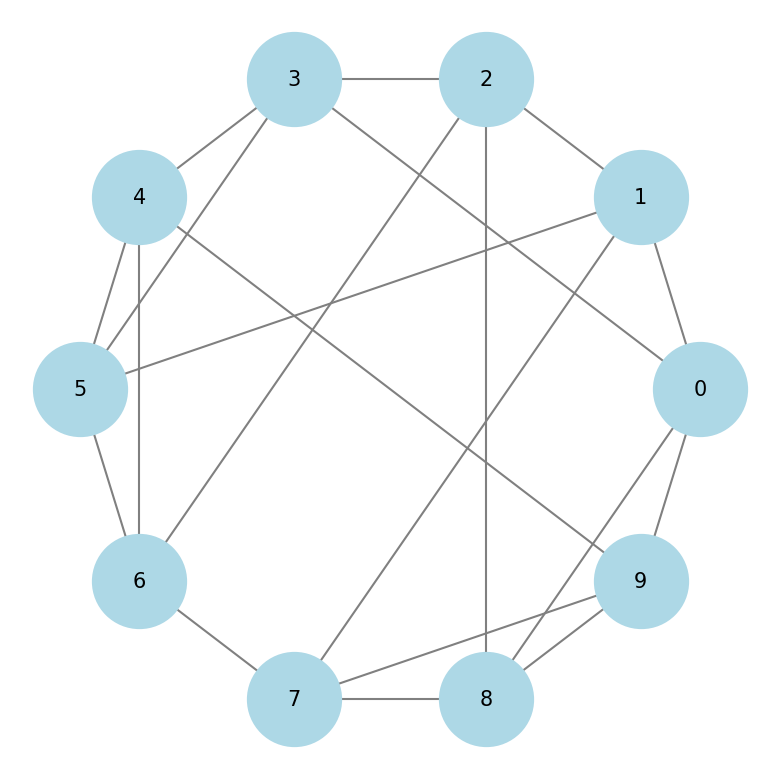

In [48]:
import networkx as nx
G = nx.from_numpy_array(n_neighbors)
pos = nx.circular_layout(G)

plt.figure(figsize=(5, 5), dpi=150)
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
#plt.title("Visualization of model (b) with $n=10$", fontsize=32, pad=35)



plt.savefig("/Users/nielsaugustdavidsen/Documents/GitHub/CP_2025/midterm1/figurer/model_b_visualization.png", bbox_inches='tight')

plt.show()


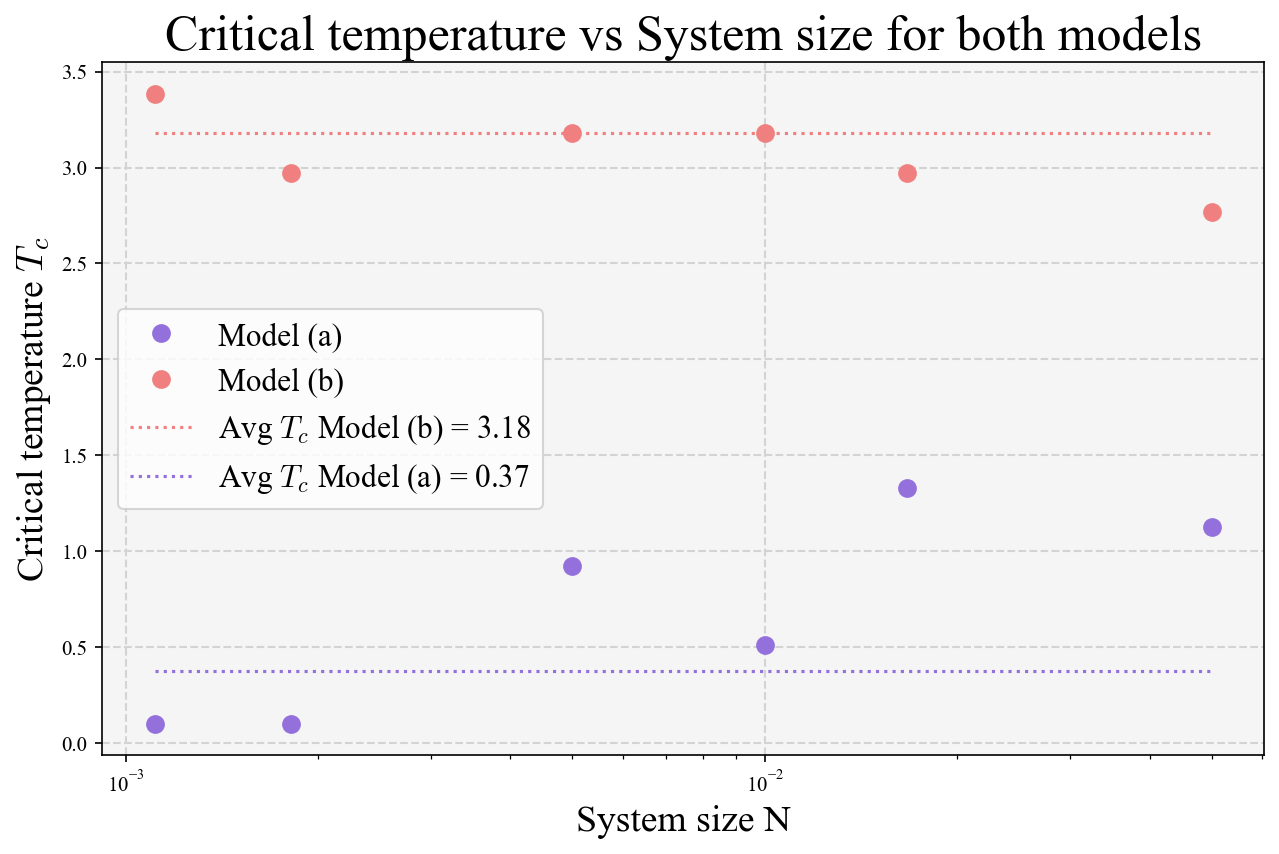

In [67]:
tc_list_a = []
tc_list_b = []
temp = df["Temperature"].values

for n in n_list:
    mag_a = df[f"Magnetization_a_n{n}"].values
    mag_b = df[f"Magnetization_b_n{n}"].values

    tc_a = find_tc(mag_a, temp, threshold=0.05)
    tc_b = find_tc(mag_b, temp, threshold=0.05)

    tc_list_a.append(tc_a)
    tc_list_b.append(tc_b)


fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.plot(1/np.array(n_list), tc_list_a, label="Model (a)", color='mediumpurple', marker='o', ls='', markersize=8)
ax.plot(1/np.array(n_list), tc_list_b, label="Model (b)", color='lightcoral', marker='o', ls='', markersize=8)
ax.set_xlabel("System size N", fontsize=18)
ax.set_ylabel(r"Critical temperature $T_c$", fontsize=18)
ax.set_facecolor('whitesmoke')
ax.set_title("Critical temperature vs System size for both models", fontsize=24)
ax.grid(color='lightgrey', linestyle='--', linewidth=1)

ax.set_xscale('log')

# Find avg of tc_list_b above n=100
avg_tc_b = np.mean([tc for n, tc in zip(n_list, tc_list_b) if n > 100])
avg_tc_a = np.mean([tc for n, tc in zip(n_list, tc_list_a) if n > 100])
ax.hlines(avg_tc_b, 1/900, 1/20, colors='lightcoral', linestyles='dotted', label=f'Avg $T_c$ Model (b) = {avg_tc_b:.2f}')
ax.hlines(avg_tc_a, 1/900, 1/20, colors='mediumpurple', linestyles='dotted', label=f'Avg $T_c$ Model (a) = {avg_tc_a:.2f}')

ax.legend(fontsize=15, loc='center left');

plt.savefig("figurer/midterm1_question2_tc_vs_n.png", bbox_inches='tight')
